### Finetuning for classification

IN this section, we are going to finetune a pretrained llm for classification

We use classification finetuning for specified tasks and instruction one for more versatile task

In the remainder of this chapter, we will modify and classification-finetune the GPT model
we implemented and pretrained in the previous chapters. We begin with downloading and
preparing the dataset

#### Preparing the data

In [2]:
#downloading and unzippinf the dataset
import urllib.request
import zipfile
import os
from pathlib import Path


url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip" 
zip_path = "sms_spam_collection.zip"
extracted_path = "sms_spam_collection"
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"

def download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path):
    if data_file_path.exists():
        print(f"{data_file_path} already exists. Skipping download and extraction.")
        return

    # Download the zip file
    with urllib.request.urlopen(url) as response:
        with open(zip_path, "wb") as out_file:
            out_file.write(response.read())
        
    
    #unzipping the file
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extracted_path)

    #adding a .tsv file extantion
    original_file_path = Path(extracted_path) / "SMSSpamCollection"
    os.rename(original_file_path, data_file_path)
    print(f"Data downloaded and extracted to {data_file_path}")



In [3]:
download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)

sms_spam_collection/SMSSpamCollection.tsv already exists. Skipping download and extraction.


In [4]:
#loading the data
import pandas as pd
df = pd.read_csv(data_file_path, sep="\t", header=None, names=["Label", "Text"])
df

,Label,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [5]:
#class and label distribution
print(df['Label'].value_counts())

Label
ham     4825
spam     747
Name: count, dtype: int64


Let's create a balanced dataset with 747 instance of each class for our purpose.
NB: there is ways to handle unbalanced data but for simplicity we will create a balanced dataset

some unbalanced data handling techniques:
- SMOTE (Synthetic Minority Over-sampling Technique): over sampling the minority label 
- ponderate the label in cross entropie calculation

In [6]:
def create_balanced_data_set(df):
    num_spam = df[df["Label"] == "spam"].shape[0]  #A
    ham_subset = df[df["Label"] == "ham"].sample(num_spam, random_state=123) #B
    balanced_df = pd.concat([ham_subset, df[df["Label"] == "spam"]]) #C
    return balanced_df
balanced_df = create_balanced_data_set(df)
print(balanced_df['Label'].value_counts())
#A Count the instances of "spam"
#B Randomly sample "ham" instances to match the number of "spam" instances
#C Combine ham "subset" with "spam"

Label
ham     747
spam    747
Name: count, dtype: int64


In [7]:
#Converting labels to binary values
balanced_df["Label"] = balanced_df["Label"].map({"ham": 0, "spam": 1})  

We create a random_split function to split the dataset into three parts: 70% for
training, 10% for validation, and 20% for testing. (These ratios are common in machine
learning to train, adjust, and evaluate models.)

In [8]:
def random_split(df, train_frac, validation_frac):
    df = df.sample(frac=1, random_state=123).reset_index(drop=True)  #A

    train_end = int(len(df) * train_frac) #B
    validation_end = train_end + int(len(df) * validation_frac)  #C

    train_df = df[:train_end]
    validation_df = df[train_end:validation_end]
    test_df = df[validation_end:]  

    return train_df, validation_df, test_df
#A Shuffle the entire DataFrame
#B Calculate split indices
#C Split the DataFrame

In [9]:
train_df, validation_df, test_df = random_split(balanced_df, 0.7, 0.1) #D
#D Test size is implied to be 0.2 as the remainder

In [10]:
#we can save these datasets to csv files if needed to use later
train_df.to_csv("train.csv", index=None)
validation_df.to_csv("validation.csv", index=None)
test_df.to_csv("test.csv", index=None)

#### Creating data loaders in pytorch for the training

#there is data of diffeerent lenfht (the text message). 
2 options to create batches:
 - Truncate all messages to the length of the shortest message in the
dataset or batch
- Pad all messages to the length of the longest message in the dataset or
batch.

We opte for the second method to not loss information.
we use "<|endoftext|>" token as padding token. but we don't add it directly, we w'll add it token id to text token list

In [11]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


Creating SpamDataset

In [12]:
import torch
from torch.utils.data import Dataset

class SpamDataset(Dataset):
    def __init__(self, csv_file, tokenizer, max_length=None, pad_token_id=50256):
        self.data = pd.read_csv(csv_file)

        self.encoded_texts = [
            tokenizer.encode(text) for text in self.data["Text"]
        ]

        if max_length is None:
            self.max_length = self._longest_encoded_length()
        else:
            self.max_length = max_length

            self.encoded_texts = [  #B Truncate sequences if they are longer than max_length
                encoded_text[:self.max_length] for encoded_text in self.encoded_texts
            ]
        
        #C Pad sequences to the longest sequence
        self.encoded_texts = [
            encoded_text + [pad_token_id]* (self.max_length - len(encoded_text))
            for encoded_text in self.encoded_texts
        ]

    
    def __getitem__(self, index):
        encoded_text = self.encoded_texts[index]
        label = self.data.iloc[index]["Label"]
        return (
            torch.tensor(encoded_text, dtype=torch.long),
            torch.tensor(label, dtype=torch.long)
        )
    
    def __len__(self):
        return len(self.data)
    
    def _longest_encoded_length(self):
        max_length = 0
        for encoded_text in self.encoded_texts:
            encoded_length = len(encoded_text)
            if encoded_length > max_length:
                max_length = encoded_length
        return max_length


In [13]:
#train_dataser
train_dataset = SpamDataset(
    csv_file="train.csv",
    max_length=None,
    tokenizer=tokenizer,
)
print(train_dataset.max_length)
#NB: max length should not be more then 1024 as gpt-2 has a limit of 1024 tokens

120


In [14]:
val_dataset = SpamDataset(
    csv_file="validation.csv",
    max_length=train_dataset.max_length, #we use that to ensure that all datasets have the same length
    tokenizer=tokenizer
)
test_dataset = SpamDataset(
    csv_file="test.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)

In [15]:
#creating dataloaders
from torch.utils.data import DataLoader
num_workers = 0  #A
batch_size =8
torch.manual_seed(123)

train_loader = DataLoader(
    dataset = train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True, 
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)


test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

#A This setting ensures compatibility with most computers

In [16]:
for input_batch, target_batch in train_loader:
    pass
print("Input batch dimensions:", input_batch.shape)
print("Label batch dimensions", target_batch.shape)
    

Input batch dimensions: torch.Size([8, 120])
Label batch dimensions torch.Size([8])


In [17]:
#total size:
print(f"{len(train_loader)} training batches")
print(f"{len(val_loader)} validation batches")
print(f"{len(test_loader)} test batches")

130 training batches
19 validation batches
38 test batches


#### Preparing the model for finetuning

In [18]:
#""model loading"
CHOOSE_MODEL = "gpt2-small (124M)"
INPUT_PROMPT = "Every effort moves"
BASE_CONFIG = {
    "vocab_size": 50257,  #the vocab size of gpt-2
    "context_length": 1024, #the context length of gpt-2
    "drop_rate": 0.0, #dropout rate
    "qkv_bias": True, #add bias to qkv projections
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

assert train_dataset.max_length <= BASE_CONFIG["context_length"], (
    f"Dataset length {train_dataset.max_length} exceeds model context length "
    f"{BASE_CONFIG['context_length']}. Please choose a model with larger context length"
    f" or set the dataset max length to `max_length={BASE_CONFIG['context_length']}` when instantiating the dataset."
) 

In [19]:
# next we use function for last chapter to load the model
import sys
import pathlib
sys.path.append('..')
from gpt_download import download_and_load_gpt2
from utils import GPTModel, load_weights_into_gpt

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(model_size = model_size, models_dir="../pretraining_on_unlabelled_data/gpt2")

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval()

File already exists and is up-to-date: ../pretraining_on_unlabelled_data/gpt2/124M/checkpoint
File already exists and is up-to-date: ../pretraining_on_unlabelled_data/gpt2/124M/encoder.json
File already exists and is up-to-date: ../pretraining_on_unlabelled_data/gpt2/124M/hparams.json
File already exists and is up-to-date: ../pretraining_on_unlabelled_data/gpt2/124M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: ../pretraining_on_unlabelled_data/gpt2/124M/model.ckpt.index
File already exists and is up-to-date: ../pretraining_on_unlabelled_data/gpt2/124M/model.ckpt.meta
File already exists and is up-to-date: ../pretraining_on_unlabelled_data/gpt2/124M/vocab.bpe


GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

In [27]:
#test of the model
from utils import generate , text_to_token_ids, token_ids_to_text

text_1 = "Every effort moves you"
token_ids = generate(
    model=model,
    idx = text_to_token_ids(text_1, tokenizer),
    max_new_tokens=15,
    context_size=BASE_CONFIG["context_length"],
    temperature=1.0,
    top_k=10,
)
print(token_ids_to_text(token_ids, tokenizer))

Every effort moves you along in a very different direction than it used to, but you are always


Let's see if the model can do classification before finetuning

In [31]:
text_2 = (
    "Is the following text 'spam'? Answer with 'yes' or 'no':"
    " 'You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award.'"
)
token_ids = generate(
    model=model,
    idx=text_to_token_ids(text_2, tokenizer),
    max_new_tokens=23,
    context_size=BASE_CONFIG["context_length"],
    top_k=1
)
print(token_ids_to_text(token_ids, tokenizer))

Is the following text 'spam'? Answer with 'yes' or 'no': 'You are a winner you have been specially selected to receive $1000 cash or a $2000 award.'

The following text 'spam'? Answer with 'yes' or 'no': 'You are a winner


#### Preparation for classification-finetuning

##### Adding a classification head

In [32]:
#lets see the odel architechture
print(model)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

FINETUNING SELECTED LAYERS VERSUS ALL LAYERS

Since we start with a pretrained model, it's not necessary to finetune all model
layers. This is because, in neural network-based language models, the lower layers
generally capture basic language structures and semantics that are applicable across
a wide range of tasks and datasets. So, finetuning only the last layers (layers near
the output), which are more specific to nuanced linguistic patterns and task-specific
features, can often be sufficient to adapt the model to new tasks. A nice side effect is
that it is computationally more efficient to finetune only a small number of layers

To get the model ready for classification-finetuning, we first freeze the model, meaning that
we make all layers non-trainable

In [33]:
for param in model.parameters():
    param.requires_grad = False

# all layers are non-trainable (frozen)

In [ ]:
#we replce the out_pout layer
torch.manual_seed(123)
num_classes = 2
model.out_head = torch.nn.Linear(in_features=BASE_CONFIG["emb_dim"], out_features=num_classes)

# the new model.out_head output layer has its requires_grad attribute set to True by
# default, which means that it's the only layer in the model that will be updated during
# training.

NB: finetuning just last layer give good results, but from experiments finetuning additional layers can considerably increase performance. (see Appendix C of the course book)


In [36]:
# So additionaly we configure the last transformer block and the final LayerNorm module,
# which connects this block to the output layer, to be trainable

for param in model.trf_blocks[-1].parameters():
    param.requires_grad = True
for param in model.final_norm.parameters():
    param.requires_grad = True

In [37]:
#we can still use the model even if some layers are frozen
inputs = tokenizer.encode("Do you have time")
inputs = torch.tensor(inputs).unsqueeze(0)
print("Inputs:", inputs)
print("Inputs dimensions:", inputs.shape) # shape: (batch_size, num_tokens)

Inputs: tensor([[5211,  345,  423,  640]])
Inputs dimensions: torch.Size([1, 4])


In [38]:
with torch.no_grad():
    outputs = model(inputs)
print("Outputs:\n", outputs)
print("Outputs dimensions:", outputs.shape) # shape: (batch_size, num_tokens,num_classes)

Outputs:
 tensor([[[-1.5883,  0.9920],
         [-3.7208,  7.4510],
         [-2.2642,  6.6005],
         [-3.5965,  3.9889]]])
Outputs dimensions: torch.Size([1, 4, 2])


before a similar input would have produced an output tensor of [1, 4, 50257].

In [39]:
# to extract the last output token:
print("Last output token predictions:\n", outputs[:, -1, :])

Last output token predictions:
 tensor([[-3.5965,  3.9889]])


Given the causal attention mask setup, the last token in a sequence
accumulates the most information since it is the only token with access to data from all the
previous tokens. Therefore, in our spam classification task, we focus on this last token
during the finetuning process.
Having modified the model, the next section will detail the process of transforming the
last token into class label predictions and calculate the model's initial prediction accuracy.
Following this, we will finetune the model for the spam classification task in the subsequent
section.

##### Evaluation functions

In [ ]:
#obtaining class label of lasst code token
probas = torch.softmax(outputs[:,-1,:], dim=-1)
label = torch.argmax(probas)
print("Predicted class label:", label.item())

#predict "spam" because not trained yet

Predicted class label: 1


In [41]:
# simplification
logits = outputs[:, -1, :]
label = torch.argmax(logits)
print("Class label:", label.item())

Class label: 1


In [42]:
#accuracy function
def calc_accuracy_loader(data_loader, model, device, num_batches=None):
    model.eval()
    correct_predictions, num_examples = 0, 0
    if num_batches is None:
        num_batches = len(data_loader)
    else:
         num_batches = min(num_batches, len(data_loader))
    
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            input_batch, target_batch = input_batch.to(device), target_batch.to(device)

            with torch.no_grad():
                logits = model(input_batch)[:, -1, :]        #A
            predicted_labels = torch.argmax(logits, dim=-1)

            num_examples += predicted_labels.shape[0]
            correct_predictions += (predicted_labels == target_batch).sum().item()
        else:
            break

        return correct_predictions / num_examples
#A Extract logits of the last token for classification



Let's use the function to determine the classification accuracies across various datasets
estimated from 10 batches for efficiency:

In [43]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
torch.manual_seed(123)
train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=10)
val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=10)
test_accuracy = calc_accuracy_loader(test_loader, model, device, num_batches=10)
print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 25.00%
Validation accuracy: 50.00%
Test accuracy: 62.50%


In [45]:
# we define a lost function that is differanciable for the training process
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)[:, -1, :] # Logits of last output token
    loss = torch.nn.functional.cross_entropy(logits, target_batch)
    return loss

In [46]:
# for a loader:
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:                                                               #A
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches
#Similar to calculating the training accuracy, we now compute the initial loss for each
#data set:
with torch.no_grad():                                                       #B
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)
    test_loss = calc_loss_loader(test_loader, model, device, num_batches=5)

#A Ensure number of batches doesn't exceed batches in data loader
#B Disable gradient tracking for efficiency because we are not training, yet

In [47]:
print(f"Training loss: {train_loss:.3f}")
print(f"Validation loss: {val_loss:.3f}")
print(f"Test loss: {test_loss:.3f}")

Training loss: 3.200
Validation loss: 2.575
Test loss: 2.314


##### Finetuning the model on supervised data

In [48]:
#evaluation function
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

In [49]:
#finetuning the model to classify spam
def train_classifier_simple(model, train_loader, val_loader, optimizer, device,
num_epochs, eval_freq, eval_iter, tokenizer):
    # Initialize lists to track losses and examples seen
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    examples_seen, global_step = 0, -1
    # Main training loop
    for epoch in range(num_epochs):
        model.train() #A
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() #B
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() #C
            optimizer.step() #D
            examples_seen += input_batch.shape[0] #E
            global_step += 1
            #F
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")
        #G
        train_accuracy = calc_accuracy_loader(
            train_loader, model, device, num_batches=eval_iter
        )
        val_accuracy = calc_accuracy_loader(
            val_loader, model, device, num_batches=eval_iter
        )
        print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")
        print(f"Validation accuracy: {val_accuracy*100:.2f}%")
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)

    return train_losses, val_losses, train_accs, val_accs, examples_seen

#A Set model to training mode
#B Reset loss gradients from previous batch iteration
#C Calculate loss gradients
#D Update model weights using loss gradients
#E New: track examples instead of tokens
#F Optional evaluation step
#G Calculate accuracy after each epoch

In [50]:
# " effective training""

import time

start_time = time.time()
torch.manual_seed(123)
optimiser = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)
num_epochs = 5

train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    model, train_loader, val_loader, optimiser, device,
    num_epochs=num_epochs, eval_freq=50, eval_iter=5,
    tokenizer=tokenizer
)

end_time = time.time()
execution_time_in_minutes = (end_time - start_time) / 60
print(f"Training completed in: {execution_time_in_minutes:.2f} minutes")

/home/ensimag/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


Ep 1 (Step 000000): Train loss 2.146, Val loss 2.383
Ep 1 (Step 000050): Train loss 0.617, Val loss 0.637
Ep 1 (Step 000100): Train loss 0.524, Val loss 0.558
Training accuracy: 62.50% | Validation accuracy: 75.00%
Ep 2 (Step 000150): Train loss 0.561, Val loss 0.489
Ep 2 (Step 000200): Train loss 0.419, Val loss 0.397
Ep 2 (Step 000250): Train loss 0.409, Val loss 0.354
Training accuracy: 75.00% | Validation accuracy: 87.50%
Ep 3 (Step 000300): Train loss 0.334, Val loss 0.320
Ep 3 (Step 000350): Train loss 0.341, Val loss 0.308
Training accuracy: 87.50% | Validation accuracy: 100.00%
Ep 4 (Step 000400): Train loss 0.144, Val loss 0.210
Ep 4 (Step 000450): Train loss 0.157, Val loss 0.136
Ep 4 (Step 000500): Train loss 0.224, Val loss 0.139
Training accuracy: 100.00% | Validation accuracy: 100.00%
Ep 5 (Step 000550): Train loss 0.207, Val loss 0.145
Ep 5 (Step 000600): Train loss 0.085, Val loss 0.075
Training accuracy: 100.00% | Validation accuracy: 100.00%
Training completed in: 18.

In [51]:
#plotting the loss function
import matplotlib.pyplot as plt
def plot_values(epochs_seen, examples_seen, train_values, val_values, label="loss"):
    fig, ax1 = plt.subplots(figsize=(5, 3))
    #A
    ax1.plot(epochs_seen, train_values, label=f"Training {label}")
    ax1.plot(epochs_seen, val_values, linestyle="-.", label=f"Validation {label}")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()
    #B
    ax2 = ax1.twiny()
    ax2.plot(examples_seen, train_values, alpha=0) # Invisible plot for aligning ticks
    ax2.set_xlabel("Examples seen")
    fig.tight_layout() #C
    # plt.savefig(f"{label}-plot.pdf")
    plt.show()

#A Plot training and validation loss against epochs
#B Create a second x-axis for examples seen
#C Adjust layout to make room

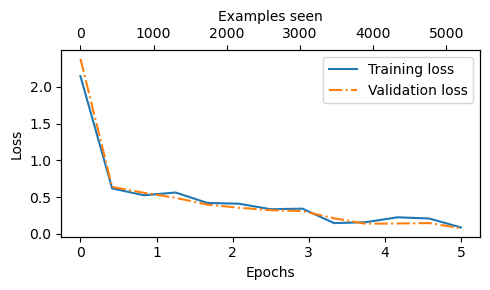

In [52]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))
plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

This graph shows the model's training and validation loss over the five training epochs. The training
loss, represented by the solid line, and the validation loss, represented by the dashed line, both sharply decline
in the first epoch and gradually stabilize towards the fifth epoch. This pattern indicates good learning progress
and suggests that the model learned from the training data while generalizing well to the unseen validation
data

In [ ]:
#Choosing the number of epochs. There is not rule. If overfitting occurs, reduce the number of epochs
#else increase it.
#In this case 5 epochs seems resonable as the model learns quickly and does not overfit

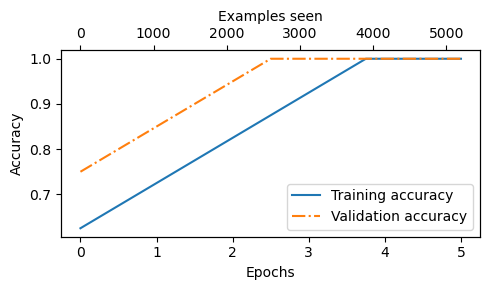

In [53]:
# Using the same plot_values function, let's now also plot the classification accuracies:
epochs_tensor = torch.linspace(0, num_epochs, len(train_accs))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_accs))
plot_values(epochs_tensor, examples_seen_tensor, train_accs, val_accs, label="accuracy")

accuracy for all the entire data in each loaders


In [54]:
train_accuracy = calc_accuracy_loader(train_loader, model, device)
val_accuracy = calc_accuracy_loader(val_loader, model, device)
test_accuracy = calc_accuracy_loader(test_loader, model, device)
print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 100.00%
Validation accuracy: 100.00%
Test accuracy: 100.00%


our model learn very very greatly

In [55]:
#function to use the model for prediction
def classify_review(text, model, tokenizer, device, max_length=None, pad_token_id=50256):
    model.eval()
    input_ids = tokenizer.encode(text) #A
    supported_context_length = model.pos_emb.weight.shape[1]
    input_ids = input_ids[:min(max_length, supported_context_length)] #B
    input_ids += [pad_token_id] * (max_length - len(input_ids)) #C
    input_tensor = torch.tensor(input_ids, device=device).unsqueeze(0) #D
    with torch.no_grad(): #E
        logits = model(input_tensor)[:, -1, :] #F
    predicted_label = torch.argmax(logits, dim=-1).item()
    return "spam" if predicted_label == 1 else "not spam" #G

#A Prepare inputs to the model
#B Truncate sequences if they too long
#C Pad sequences to the longest sequence
#D Add batch dimension
#E Model inference without gradient tracking
#F Logits of the last output token
#G Return the classified resul

In [56]:
# "trying"
text_1 = (
"You are a winner you have been specially"
" selected to receive $1000 cash or a $2000 award."
)
print(classify_review(
    text_1, model, tokenizer, device, max_length=train_dataset.max_length
))

spam


In [64]:
# "another test"
text_2 = (
"Hey, just wanted to check if we're still on"
" for dinner tonight? Let me know!"
)
print(classify_review(
    text_2, model, tokenizer, device, max_length=train_dataset.max_length))

not spam


In [66]:
text_3 = (
"your account has been compromised. Please send us your password"
)
print(classify_review(
    text_3, model, tokenizer, device, max_length=train_dataset.max_length
))

not spam


In [67]:
# Let's save it for further use
torch.save(model.state_dict(), "finetuned_gpt2_124M_spam_classifier.pth")